In [1]:
%load_ext autoreload
%autoreload 2

import sys; 
sys.path.insert(0, '../../esinet')
sys.path.insert(0, '../')

import numpy as np
from copy import deepcopy
from scipy.sparse.csgraph import laplacian
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from scipy.sparse.csgraph import laplacian

pp = dict(surface='white', hemi='both')

In [2]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape
dist = cdist(pos, pos)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.6s remaining:    4.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.8s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


In [3]:
# settings = dict(number_of_sources=1, extents=40, duration_of_trial=0.01, target_snr=99999999999)
settings = dict(number_of_sources=1, extents=(1, 40), duration_of_trial=0.001, target_snr=99999)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()
y = evoked.data
x = stc.data

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)

Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 166.65it/s]


Using pyvistaqt 3d backend.

Using control points [0.00000000e+00 0.00000000e+00 5.92231526e-08]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


# Algo

## Helpers

ye
(5, 64, 64, 1) (5, 1284)
No projector specified for this dataset. Please consider the method self.add_proj.


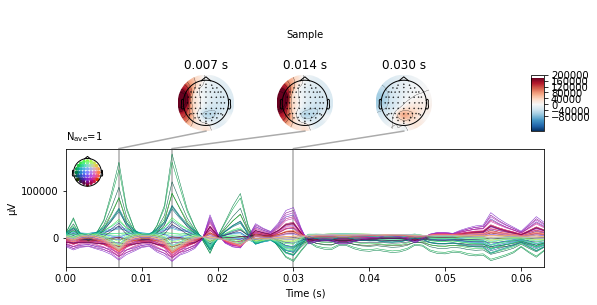

Using control points [0.         0.0045492  0.19926407]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


In [5]:
def generator(fwd, batch_size=1284, batch_repetitions=30, n_sources=2, n_orders=4, amplitude_range=(0.001,1), n_timepoints=20, verbose=0):
    adjacency = mne.spatial_src_adjacency(fwd["src"], verbose=verbose).toarray()
    gradient = abs(laplacian(adjacency))
    leadfield = fwd["sol"]["data"]
    leadfield -= leadfield.mean()

    # leadfield_norm = deepcopy(leadfield)
    # leadfield_norm /= np.linalg.norm(leadfield_norm, axis=0)

    n_chans, n_dipoles = leadfield.shape


    sources = np.identity(n_dipoles)
    for _ in range(n_orders-1):
        new_sources = sources[-n_dipoles:, -n_dipoles:] @ gradient
        new_sources /= new_sources.max(axis=0)
        sources = np.concatenate( [sources, new_sources], axis=0 )

    time_courses = np.stack([np.random.randn(n_timepoints) for _ in range(1000)], axis=0)

    

    n_candidates = sources.shape[0]

    while True:
        print("ye")
        # select sources and their amplitudes
        n_sources_batch = np.random.randint(1, n_sources+1, batch_size)
        selection = [np.random.randint(0, n_candidates, n) for n in n_sources_batch]
        amplitudes = [time_courses[np.random.choice(np.arange(time_courses.shape[0]), n)].T for n in n_sources_batch]

        y = np.stack([(amplitudes[i] @ sources[selection[i]]) / len(amplitudes[i]) for i in range(batch_size)], axis=0)
        
        # temporalize
        
        
        
        
        x = np.stack([leadfield @ yy.T for yy in y], axis=0)

        # scale x
        x = np.stack([xx - xx.mean(axis=0) for xx in x], axis=0)
        cov = np.stack([xx@xx.T for xx in x], axis=0)
        cov = np.stack([C / np.linalg.norm(C) for C in cov], axis=0)
        cov = np.expand_dims(cov, axis=-1)
        y = np.stack([np.linalg.norm(yy, axis=0) for yy in y ], axis=0)

        for _ in range(batch_repetitions):
            yield (cov, y)


gen = generator(fwd, batch_size=5, n_sources=4, n_timepoints=20)
x_test, y_test = gen.__next__()
print(x_test.shape, y_test.shape)
i = 0
evoked_ = mne.EvokedArray(x_test[i, :, :, 0].T, evoked.info)
evoked_.plot_joint(title="Sample")

stc_ = stc.copy()

stc_.data[:, 0] = y_test[i]
stc_.plot(**pp)

# Training

## CNN

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras import backend as K
tf.keras.backend.set_image_data_format('channels_last')

n_channels = evoked.data.shape[0]
n_dipoles = x.shape[0]

# Architecture Params
n_filters = n_channels
filter_size = (1, n_channels)
activation_function = "relu"
batch_size = int(n_dipoles*3)

# Simulation Params
n_sources = 15
n_orders = 3
n_timepoints = 20
batch_repetitions = 30

# Training Params
epochs = 20
steps_per_epoch = batch_repetitions

n_hl = 0

inputs = tf.keras.Input(shape=(n_channels, n_channels, 1), name='Input')

cnn1 = Conv2D(n_filters, filter_size,
            activation=activation_function, padding="valid",
            name='CNN1')(inputs)

for n in range(n_hl):
    cnn1 = Conv2D(n_filters, filter_size,
            activation=activation_function, padding="valid",
            name='CNN' + str(n+2))(cnn1)

flat = Flatten()(cnn1)

hl_fin = Dense(300, 
            activation="relu", 
            name='HLfin')(flat)

out = Dense(n_dipoles, 
            activation="relu", 
            name='Output')(hl_fin)

model = tf.keras.Model(inputs=inputs, outputs=out, name='AutoANN')
model.compile(loss="cosine_similarity", optimizer="adam")
model.summary()

gen = generator(fwd, batch_size=batch_size, batch_repetitions=batch_repetitions, 
                n_sources=n_sources, n_orders=n_orders, n_timepoints=n_timepoints)

model.fit(x=gen, epochs=epochs,  steps_per_epoch=steps_per_epoch)


Model: "AutoANN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 64, 64, 1)]       0         
                                                                 
 CNN1 (Conv2D)               (None, 64, 1, 64)         4160      
                                                                 
 flatten_10 (Flatten)        (None, 4096)              0         
                                                                 
 HLfin (Dense)               (None, 300)               1229100   
                                                                 
 Output (Dense)              (None, 1284)              386484    
                                                                 
Total params: 1,619,744
Trainable params: 1,619,744
Non-trainable params: 0
_________________________________________________________________
ye
Epoch 1/20
30/30 [============================

## LSTM

In [88]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, LSTM, Bidirectional
from tensorflow.keras import backend as K
tf.keras.backend.set_image_data_format('channels_last')

n_channels = evoked.data.shape[0]
n_dipoles = x.shape[0]

n_lstm_units = 150
activation_function = "relu"
batch_size = n_dipoles
n_sources = 5
n_orders = 5
batch_repetitions = 30

epochs = 20
steps_per_epoch = batch_repetitions
n_hl = 1

inputs = tf.keras.Input(shape=(None, n_channels), name='Input')

lstm1 = Bidirectional(LSTM(n_lstm_units, return_sequences=True, name='LSTM1'))(inputs)

# for n in range(n_hl):
#     lstm1 = Bidirectional(LSTM(n_lstm_units, return_sequences=True, name='LSTM'+str(n+2)))(lstm1)
            
out = TimeDistributed(Dense(n_dipoles, 
            activation="linear", 
            name='Output'))(lstm1)

model = tf.keras.Model(inputs=inputs, outputs=out, name='AutoANN')
model.compile(loss="cosine_similarity", optimizer="adam")
model.summary()

gen = generator(fwd, batch_size=batch_size, batch_repetitions=batch_repetitions, 
                n_sources=n_sources, n_orders=n_orders, n_timepoints=3)

model.fit(x=gen, epochs=epochs,  steps_per_epoch=steps_per_epoch)

gen = generator(fwd, batch_size=batch_size, batch_repetitions=batch_repetitions, 
                n_sources=n_sources, n_orders=n_orders, n_timepoints=15)

model.fit(x=gen, epochs=epochs,  steps_per_epoch=steps_per_epoch)



Model: "AutoANN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, None, 64)]        0         
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 300)        258000    
 nal)                                                            
                                                                 
 time_distributed_10 (TimeDi  (None, None, 1284)       386484    
 stributed)                                                      
                                                                 
Total params: 644,484
Trainable params: 644,484
Non-trainable params: 0
_________________________________________________________________
ye
Epoch 1/20
30/30 [==============================] - 10s 222ms/step - loss: -0.1336
Epoch 2/20
30/30 [==============================] - 6s 201ms/step - loss: -0.2338
Epoch 3/20
30/30 

KeyboardInterrupt: 

# Eval

In [18]:
x_test, y_test = gen.__next__()

y_hat = model.predict(x_test, verbose=0)

stc_ = stc.copy()
stc_.data = y_test.T
stc_.plot(**pp, brain_kwargs=dict(title="Ground Truths"))

stc_ = stc.copy()
stc_.data = y_hat.T
stc_.plot(**pp, brain_kwargs=dict(title="Preds"))

Using control points [0.00188273 0.01087466 0.24899622]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
Using control points [0.         0.         0.01166691]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


Using control points [0.         0.         0.00558465]
Using control points [0.0058865  0.0302676  0.22112114]
Using control points [0.         0.         0.00558465]
Using control points [0.0000000e+00 3.6024861e-05 1.1242227e-02]
Using control points [0.01494373 0.02863816 0.21657167]
